# Find Asteroids

In this notebook we present a procedure to detect moving objects (asteroid or in general small bodies) in a set of images taken at different epochs.

The idea is to detect a moving object in a set of images like this:

![alt text][asteroid]
[asteroid]: images/asteroid.gif

For performing this task we use different tools:

- [SEXtractor](https://www.astromatic.net/software/sextractor), for extracting the sources
- [Astrometry.net](http://astrometry.net/doc/readme.html), for performing astrometry on the image and find the reference stars.



## Required modules

The following modules are required

In [847]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model
import glob
from collections import OrderedDict
import collections
import pandas as pd
from os import system
import warnings
warnings.filterwarnings('ignore')

%matplotlib nbagg

## Locations

Determine where the required information and executables are located

In [189]:
DATA_DIR="data/"
SETS_DIR=DATA_DIR+"sets/"
REP_DIR=DATA_DIR+"reports/"
IMAGE_DIR="images/"
SCR_DIR="scratch/"
INPUT_DIR="input/"
AST_DIR="/home/astrometry/astrometry/"
SEX_DIR="/home/astrometry/sextractor/"

## Set of images & Configuration

In [589]:
SET="ps1-20170914_4_set096"
CFG=SET.split("-")[0]+".cfg"
cfg=[line.rstrip('\n') for line in open(SETS_DIR+CFG)]
cfg

['[Settings]',
 'ApertureRadius=5',
 'ApertureGap=1',
 'SigmaLimit=4.0',
 'MinFWHM=1.20',
 'FitRMS=0.25',
 'SearchRadius=0.75',
 'Catalog=7',
 'MinMag=25.0',
 'MaxMag=13.0',
 'PosResidual=0.40',
 'MagResidual=0.70',
 'FitOrder=3',
 'NoMatch=100',
 'MatchRadius=2.00',
 'NoAlign=30',
 'AlignPixels=0',
 'SplitLine=1',
 'IncludeMag=1',
 'ExtraDigit=1',
 'ExtraDigitMag=0',
 'PixelWide=0.0100',
 'PixelHigh=0.0100',
 'Saturation=25000',
 'SkipCheck=1',
 'SaveWCS=0',
 'Color=R',
 'FocalLength=8070.0',
 'VarFocalLen=1.0',
 'PA=241.8',
 'VarPA=1.0',
 'Pointing=5.0',
 'FlipHoriz=0',
 'FlipVert=0',
 'TimeMode=0',
 'TimePrecision=0.10',
 'TimeOffset=0.00',
 'ExpTimeMode=1',
 'CheckAtStart=1',
 'AskOnClose=1',
 'Color0=255',
 'Color1=12632256',
 'Color2=16711680',
 'Color3=65280',
 'Color4=65535',
 'Color5=255',
 'Color6=16711935',
 'NoFilter=0',
 'Distortion=0.00',
 'BkGround=0',
 '[ObservingSite]',
 'MPCCode=F51',
 'Longitude=150.4170',
 'Latitude=20.7070',
 'Height=3066.0',
 'IncludeContact=0',
 

Image analysed by humans:
![alt text][report]
[report]: images/example-report.jpg

## Unpack images

In [231]:
OUT_DIR=SCR_DIR+SET+"/"
out=System("mkdir -p "+OUT_DIR)
out=System("cp "+INPUT_DIR+"template/* "+OUT_DIR)
out=System("unzip -o -d "+OUT_DIR+" "+SETS_DIR+SET+".zip")

Archive:  data/sets/ps1-20170914_4_set096.zip
  inflating: scratch/ps1-20170914_4_set096/o8010g0344o.1300829.ch.1992525.XY36.p00.fits
  inflating: scratch/ps1-20170914_4_set096/o8010g0362o.1300847.ch.1992543.XY36.p00.fits
  inflating: scratch/ps1-20170914_4_set096/o8010g0380o.1300865.ch.1992561.XY36.p00.fits
  inflating: scratch/ps1-20170914_4_set096/o8010g0398o.1300883.ch.1992579.XY36.p00.fits


## Read images

In [175]:
images=[]
for image in sorted(glob.glob(OUT_DIR+"*.fits")):
    print("Reading image "+image)
    hdul=fits.open(image)
    im=dict()
    im["file"]=image.split("/")[-1].replace(".fits","")
    im["header"]=hdul[0].header
    im["data"]=hdul[0].data
    images+=[im]
    hdul.close()


Reading image scratch/ps1-20170914_4_set096/o8010g0344o.1300829.ch.1992525.XY36.p00.fits
Reading image scratch/ps1-20170914_4_set096/o8010g0362o.1300847.ch.1992543.XY36.p00.fits
Reading image scratch/ps1-20170914_4_set096/o8010g0380o.1300865.ch.1992561.XY36.p00.fits
Reading image scratch/ps1-20170914_4_set096/o8010g0398o.1300883.ch.1992579.XY36.p00.fits


In [588]:
#Uncomment to check image headers
#images[0]["header"]

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 2423 / length of data axis 1                          
NAXIS2  =                 2434 / length of data axis 2                          
BZERO   =               32768. / Scaling: TRUE = BZERO + BSCALE * DISK          
BSCALE  =                   1. / Scaling: TRUE = BZERO + BSCALE * DISK          
DATE-OBS= '2017-09-14T09:54:45.670299' /  UTC start of exposure                 
TIMESYS = 'UTC     '           / Time scale                                     
EQUINOX =                2000. /                                                
EXPTIME =                  45. /  exposure time (sec)                           
OBJCTRA = '23 37 49.518'       / RA of center of the image                      
OBJCTDEC= '-4 05 38.469'    

In [ ]:
fig,axs=plt.subplots(2,2,sharex=True,sharey=True,figsize=(7,7))
imgargs=dict(cmap='gray',vmin=0,vmax=500)
i=0
for lax in axs:
    for ax in lax:  
        ax.imshow(images[i]["data"],**imgargs)
        images[i]["ax"]=ax
        i+=1
        
for i,ax in enumerate(mat2lst(axs)):
    ax.axis("off")
    time=images[i]["header"]["DATE-OBS"]
    ax.set_title(images[i]["file"]+"\n"+"Time:"+time,fontsize=8,position=(0.5,1.0))
    #ax.set_title("Image %d"%i,fontsize=8)
fig.tight_layout()

## Run Astrometry.net

In [762]:
for image in images:
    file=image["file"]
    header=image["header"]

    #GET COORDINATES
    ra=sex2dec(header["OBJCTRA"])*15
    dec=sex2dec(header["OBJCTDEC"])

    #ASTROMETRY.NET COMMAND
    print("Running astrometry over %s..."%file)
    opts=""
    opts+=" "+"--use-sextractor --sextractor-path "+SEX_DIR+"bin/sex"
    opts+=" "+"--no-plots"
    opts+=" "+"--ra %.7f --dec %.7f --radius 1"%(ra,dec)
    opts+=" "+"--guess-scale --overwrite"
    cmd=AST_DIR+"bin/solve-field "+opts+" "+file+".fits"
    sys="cd "+OUT_DIR+";"+cmd
    out=System(sys,False)
    if out[-1][0]!=0:
        print("Error processing image")
        print(out[-1][1])
    else:
        print("\tAstrometry processing successful")
        #STORE RESULTS
        image["astro_output"]="\n".join(out[:-1])

        #SOURCE XY AND MAG
        hdul=fits.open(OUT_DIR+"%s.axy"%file)
        image["objects_header"]=hdul[1].header
        image["objects"]=hdul[1].data
        hdul.close()

        #SOURCE RA,DEC
        cmd=AST_DIR+"bin/wcs-xy2rd -X 'X_IMAGE' -Y 'Y_IMAGE' -w %s.wcs -i %s.axy -o %s.ard"%(file,file,file)
        sys="cd "+OUT_DIR+";"+cmd
        out=System(sys,False)

        hdul=fits.open(OUT_DIR+"%s.ard"%file)
        image["objectsrd_header"]=hdul[1].header
        image["objectsrd"]=hdul[1].data
        hdul.close()
        
        #STARS X,Y
        hdul=fits.open(OUT_DIR+"%s-indx.xyls"%file)
        image["stars_header"]=hdul[1].header
        image["stars"]=hdul[1].data
        hdul.close()
    
        #STARS RA,DEC
        hdul=fits.open(OUT_DIR+"%s.rdls"%file)
        image["sources_header"]=hdul[1].header
        image["sources"]=hdul[1].data
        hdul.close()

    #break
print("Done.")

Running astrometry over o8010g0344o.1300829.ch.1992525.XY36.p00...
	Astrometry processing successful
Running astrometry over o8010g0362o.1300847.ch.1992543.XY36.p00...
	Astrometry processing successful
Running astrometry over o8010g0380o.1300865.ch.1992561.XY36.p00...
	Astrometry processing successful
Running astrometry over o8010g0398o.1300883.ch.1992579.XY36.p00...
	Astrometry processing successful
Done.


In [758]:
#Uncomment to see objects attributes
#images[0]["objects_header"]
#images[0]["stars_header"]

## Running SEXtractor

In [281]:
for image in images:
    file=image["file"]
    header=image["header"]

    #SEX COMMAND
    print("Running SEXtractor over %s..."%file)
    opts=""
    opts+=" "+"-c asteroid.sex"
    cmd=SEX_DIR+"bin/sex "+opts+" "+file+".fits"
    sys="cd "+OUT_DIR+";"+cmd
    out=System(sys)
    if out[-1][0]!=0:
        print("Error processing image")
        print(out[-1][1])
    else:
        print("\tExtraction successful")
        #STORE RESULTS
        image["sex_output"]=out[-1][1]
        System("cd "+OUT_DIR+";cp asteroid.cat %s.cat"%file,False)
        hdul=fits.open(OUT_DIR+"%s.cat"%file)
        image["catalogue_header"]=hdul[1].header
        image["catalogue"]=hdul[1].data
        hdul.close()
    #break
print("Done.")

Running SEXtractor over o8010g0344o.1300829.ch.1992525.XY36.p00...
	Extraction successful
Running SEXtractor over o8010g0362o.1300847.ch.1992543.XY36.p00...
	Extraction successful
Running SEXtractor over o8010g0380o.1300865.ch.1992561.XY36.p00...
	Extraction successful
Running SEXtractor over o8010g0398o.1300883.ch.1992579.XY36.p00...
	Extraction successful
Done.


In [318]:
#Uncomment to see catalogue stars
#images[0]["catalogue_header"]

## Showing objecs

In [671]:
for image in images:
    objects=image["objects"]
    stars=image["stars"]
    catalogue=image["catalogue"]
    ax=image["ax"]
    ax.plot(objects["X_IMAGE"],objects["Y_IMAGE"],'ro',ms=5,mfc='None')
    ax.plot(stars["X"],stars["Y"],'gs',ms=10,mfc='None')
    ax.plot(catalogue["X_IMAGE"],catalogue["Y_IMAGE"],'bv',ms=10,mfc='None')
    for i in range(len(catalogue)):
        text=str(catalogue["MAG_BEST"][i])
        text="Src.%d"%i
        ax.text(catalogue["X_IMAGE"][i],catalogue["Y_IMAGE"][i],text,
                color='w',zorder=100,fontsize=6,rotation=45,ha='left',va='bottom')
        #break
    break

## Analysing a single object

In [829]:
#Coordinates
image=images[0]
#iobj=60 #Astrometrica. SNR = 7.67 
iobj=311 #Asteroid
#iobj=201 #Close star, SNR =16.7 (brightest star)
#iobj=217 #Close star, SNR =16.7
#iobj=221 #Close star, SNR = 5.0
#iobj=299 #Close star, SNR = 4.5
x=int(image["catalogue"]["X_IMAGE"][iobj])
y=int(image["catalogue"]["Y_IMAGE"][iobj])
dx=int(np.ceil(np.sqrt(image["catalogue"]["X2_IMAGE"][iobj])))
dy=int(np.ceil(np.sqrt(image["catalogue"]["Y2_IMAGE"][iobj])))

mag=image["catalogue"]["MAG_BEST"][iobj]
ra=image["objectsrd"]["RA"][iobj]/15
dec=image["objectsrd"]["DEC"][iobj]
print("RA = (%.7f) "%ra,dec2sex(ra))
print("DEC = (%.7f) "%dec,dec2sex(dec))
print("mag = ",mag)

RA = (23.6470796)  (23.0, 38, 49.486658003722255)
DEC = (-4.1811170)  (-4.0, 10, 52.021084016381991)
mag =  -10.0746


In [731]:
#Plot on image
ax=image["ax"]
ax.plot(x,y,'wo',ms=5,mfc='None')

### Fitting in 1D

In [732]:
#Fitting over a line
#http://docs.astropy.org/en/stable/modeling/index.html
data=rec2arr(image["data"])
ws=5
xs=np.arange(x-ws*dx,x+ws*dx,1)
pxs=data[y,x-ws*dx:x+ws*dx,0]
ys=np.arange(y-ws*dy,y+ws*dy,1)
pys=data[y-ws*dy:y+ws*dy,x,0]

#Fit x
mean=x
sigma2=dx**2
xf=xs
yf=pxs

def gaussianLevel(t,level=0.0,amplitude=1.0,mean=mean,sigma2=sigma2):
    g=amplitude*np.exp(-0.5*((t-mean)**2/sigma2))
    f=g+level
    return f

g_init=custom_model(gaussianLevel)()
#fit=fitting.LevMarLSQFitter()
fit=fitting.SLSQPLSQFitter()
gx=fit(g_init,xf,yf,verblevel=0)
rs=gx(xs)-pxs
noise=rs.std()
SNRx=gx.amplitude.value/noise
print("SNR(x)=",SNRx)

#Fit y
mean=y
sigma2=dy**2
xf=ys
yf=pys

def gaussianLevel(t,level=0.0,amplitude=1.0,mean=mean,sigma2=sigma2):
    g=amplitude*np.exp(-0.5*((t-mean)**2/sigma2))
    f=g+level
    return f

g_init=custom_model(gaussianLevel)()
#fit=fitting.LevMarLSQFitter()
fit=fitting.SLSQPLSQFitter()
gy=fit(g_init,xf,yf,verblevel=0)
rs=gy(ys)-pys
noise=rs.std()

SNRy=gy.amplitude.value/noise
#SNRy=gy.amplitude.value/np.sqrt(gy.amplitude.value+gy.level.value)
#SNRy=gy.amplitude.value/np.sqrt(gy.level.value**2+5.171346**2)
print("SNR(y)=",SNRy)
print(gx,gy)

SNR(x)= 18.5625870505
SNR(y)= 2.30341275549
Model: gaussianLevel
Inputs: ('t',)
Outputs: ('t',)
Model set size: 1
Parameters:
        level       amplitude        mean        sigma2   
    ------------- ------------- ------------- ------------
    174.613600277 360.997076428 650.237682626 3.4247657922 Model: gaussianLevel
Inputs: ('t',)
Outputs: ('t',)
Model set size: 1
Parameters:
        level       amplitude        mean         sigma2   
    ------------- ------------- ------------- -------------
    248.800042579 285.343105565 1481.18540566 15.3082784658


### Plot 1D fit 

<IPython.core.display.Javascript object>


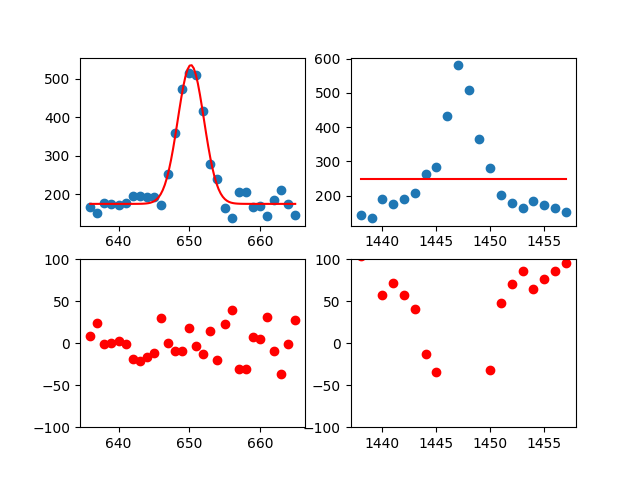

(-100, 100)

In [733]:
fig,axs=plt.subplots(2,2)

axf=axs[0][0]
axf.plot(xs,pxs,'o')
xss=np.linspace(xs[0],xs[-1],100)
axf.plot(xss,gx(xss),'r-')

axf=axs[1][0]
rs=gx(xs)-pxs
axf.plot(xs,rs,'ro')
axf.set_ylim(-100,100)

axf=axs[0][1]
axf.plot(ys,pys,'o')
yss=np.linspace(ys[0],ys[-1],100)
axf.plot(yss,gy(yss),'r-')

axf=axs[1][1]
rs=gy(ys)-pys
axf.plot(ys,rs,'ro')
axf.set_ylim(-100,100)

### Fitting in 2D

In [734]:
#Fitting over the whole PSF
sigmax2=dx**2
sigmay2=dy**2
meanx=x
meany=y
X,Y=np.meshgrid(xs,ys)
P=data[y-ws*dy:y+ws*dy,x-ws*dx:x+ws*dx,0]

def gaussianLevel2(tx,ty,level=0.0,amplitude=1.0,
                   meanx=meanx,meany=meany,
                   sigmax2=sigmax2,sigmay2=sigmay2):
    g=amplitude*np.exp(-0.5*((tx-meanx)**2/sigmax2+(ty-meany)**2/sigmay2))
    f=g+level
    return f

g_init=custom_model(gaussianLevel2)()
fit=fitting.SLSQPLSQFitter()
g=fit(g_init,X,Y,P,verblevel=1)
print(g)
print(g.meanx,g.meany)

Pth=gaussianLevel2(X,Y,
                level=g.level.value,amplitude=g.amplitude.value,
                meanx=g.meanx.value,meany=g.meany.value,
                sigmax2=g.sigmax2.value,sigmay2=g.sigmay2.value)
D=P-Pth
noise=D.std()
SNR=g.amplitude.value/noise
print("SNR(2D) = ",SNR)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 265400.9659649923
            Iterations: 25
            Function evaluations: 246
            Gradient evaluations: 25
Model: gaussianLevel2
Inputs: ('tx', 'ty')
Outputs: ('tx',)
Model set size: 1
Parameters:
        level       amplitude       meanx     ...   sigmax2       sigmay2   
    ------------- ------------- ------------- ... ------------ -------------
    164.507550143 378.070553422 650.345070204 ... 4.3240756282 3.25900257802
Parameter('meanx', value=650.3450702043309) Parameter('meany', value=1447.361556863495)
SNR(2D) =  17.9761725691


<IPython.core.display.Javascript object>


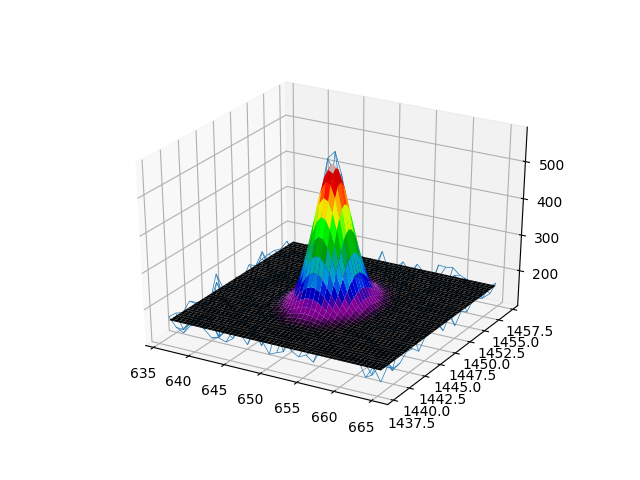

In [735]:
fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

ax3d.plot_wireframe(X,Y,P,lw=0.5)

ngrid=50
Xs,Ys=np.meshgrid(np.linspace(xs[0],xs[-1],ngrid),np.linspace(ys[0],ys[-1],ngrid))
Zs=gaussianLevel2(Xs,Ys,
                  level=g.level.value,amplitude=g.amplitude.value,
                  meanx=g.meanx.value,meany=g.meany.value,
                  sigmax2=g.sigmax2.value,sigmay2=g.sigmay2.value)

ax3d.plot_surface(Xs,Ys,Zs,cmap='nipy_spectral')

## Show only coordinates

<IPython.core.display.Javascript object>


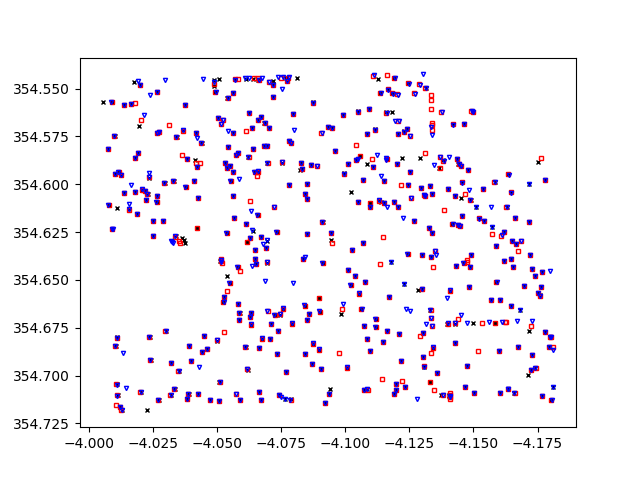

354.542368063 354.718219255


In [813]:
#READ OBJECTS
objs=[]
for i,image in enumerate(images):objs+=[rec2arr(image["objectsrd"])]
    
fig,axs=plt.subplots(1,1)

dmin=min([objs[i][:,1].min() for i in range(len(images))])
rmin=min([objs[i][:,0].min() for i in range(len(images))])
dmax=max([objs[i][:,1].max() for i in range(len(images))])
rmax=max([objs[i][:,0].max() for i in range(len(images))])

print(rmin,rmax)

axs.plot(objs[0][:,1],objs[0][:,0],'kx',ms=3)
axs.plot(objs[1][:,1],objs[1][:,0],'rs',ms=3,mfc='None')
axs.plot(objs[2][:,1],objs[2][:,0],'bv',ms=3,mfc='None')

axs.invert_xaxis()
axs.invert_yaxis()

In [816]:
image["catalogue_header"]

XTENSION= 'BINTABLE'           / THIS IS A BINARY TABLE (FROM THE LDACTOOLS)    
BITPIX  =                    8 /                                                
NAXIS   =                    2 /                                                
NAXIS1  =                   76 / BYTES PER ROW                                  
NAXIS2  =                  411 / NUMBER OF ROWS                                 
PCOUNT  =                    0 / RANDOM PARAMETER COUNT                         
GCOUNT  =                    1 / GROUP COUNT                                    
TFIELDS =                   13 / FIELDS PER ROWS                                
EXTNAME = 'OBJECTS '           / TABLE NAME                                     
TTYPE1  = 'NUMBER  '           / Running object number                          
TFORM1  = '1J      '                                                            
TDISP1  = 'I10     '                                                            
TTYPE2  = 'MAG_BEST'        

<IPython.core.display.Javascript object>


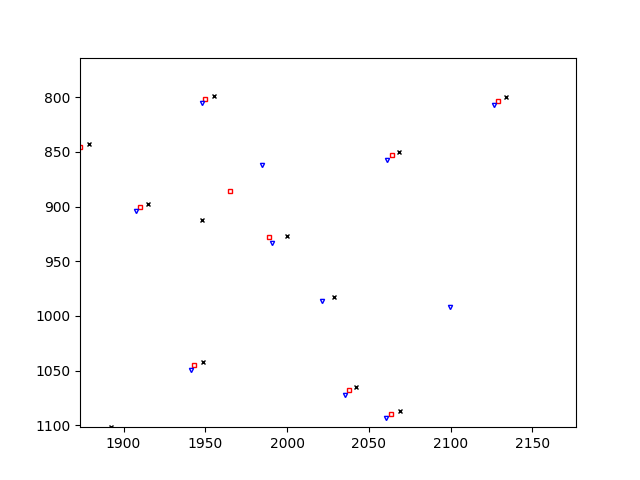

In [821]:
#READ OBJECTS
objs=[]
for i,image in enumerate(images):objs+=[rec2arr(image["catalogue"])]
    
fig,axs=plt.subplots(1,1)

axs.plot(objs[0][:,2],objs[0][:,4],'kx',ms=3)
axs.plot(objs[1][:,2],objs[1][:,4],'rs',ms=3,mfc='None')
axs.plot(objs[2][:,2],objs[2][:,4],'bv',ms=3,mfc='None')

#axs.invert_xaxis()
axs.invert_yaxis()

In [842]:
#See FITS file
image=images[0]
file=image["file"]
#hdul=fits.open(OUT_DIR+"%s-indx.xyls"%file)
#hdul=fits.open(OUT_DIR+"%s.rdls"%file)
#hdul=fits.open(OUT_DIR+"%s.wcs"%file)
hdul=fits.open(AST_DIR+"examples/tycho2-mag6.fits")
hdul[1].header
#hdul[1].data.shape

XTENSION= 'BINTABLE' / FITS Binary Table Extension                              
BITPIX  =                    8 / 8-bits character format                        
NAXIS   =                    2 / Tables are 2-D char. array                     
NAXIS1  =                   32 / Bytes in row                                   
NAXIS2  =                 4683 / no comment                                     
PCOUNT  =                    0 / Parameter count always 0                       
GCOUNT  =                    1 / Group count always 1                           
TFIELDS =                    6 / No. of col in table                            
TFORM1  = '1D      ' / Format of field                                          
TTYPE1  = 'RA      ' / Field label                                              
TUNIT1  = 'deg     ' / Physical unit of field                                   
TFORM2  = '1D      ' / Format of field                                          
TTYPE2  = 'DEC     ' / Field

In [845]:
#See FITS file
image=images[0]
file=image["file"]
#hdul=fits.open(OUT_DIR+"%s-indx.xyls"%file)
#hdul=fits.open(OUT_DIR+"%s.rdls"%file)
#hdul=fits.open(OUT_DIR+"%s.wcs"%file)
hdul=fits.open(AST_DIR+"data/astrometry-tycho2/build/index-4114.fits")
hdul[1].header
#hdul[1].data.shape

XTENSION= 'BINTABLE' / FITS Binary Table Extension                              
BITPIX  =                    8 / 8-bits character format                        
NAXIS   =                    2 / Tables are 2-D char. array                     
NAXIS1  =                   12 / Bytes in row                                   
NAXIS2  =                37632 / no comment                                     
PCOUNT  =                    0 / Parameter count always 0                       
GCOUNT  =                    1 / Group count always 1                           
TFIELDS =                    1 / No. of col in table                            
TFORM1  = '12A     ' / Format of field                                          
TTYPE1  = 'quads   ' / Field label                                              
ORIGIN  = 'ESO-QFITS' / Written by QFITS                                        
DATE    = '2017-12-31T23:38:00' / [UTC] Date of writing                         

## Useful routines and Macros

In [769]:
#Get configuration line from a list  
#Example: Config(cfg,"Latitude")
Config=lambda c,x:[s for s in c if x in s]

#Convert from sexagesimal to decimal
#Example: sex2dec("23 03 45")
sex2dec=lambda s:np.sign(float(s.split()[0]))*(np.array([np.abs(float(x)) for x in s.split()]).dot([1.0,1/60.0,1/3600.]).sum())

def dec2sex(d):
    s=np.sign(d)
    d=np.abs(d)
    dg=int(d)
    mm=(d-dg)*60
    mg=int(mm)
    sg=(mm-mg)*60
    return s*dg,mg,sg


#Convert a matrix of axes into a list
mat2lst=lambda M:M.reshape(1,sum(M.shape))[0].tolist()

#Intelligent Shell script execution
def _run(cmd):
    import sys,subprocess
    p=subprocess.Popen(cmd,stdout=subprocess.PIPE,stderr=subprocess.PIPE,shell=True)
    while True:
        line = p.stdout.readline().rstrip()
        if not line:
            break
        yield line
    (output,error)=p.communicate()
    yield p.returncode,error

def System(cmd,verbose=True):
    out=[]
    for path in _run(cmd):
        try:
            if verbose:print(path.decode("utf-8"))
            out+=[path.decode("utf-8")]
        except:
            out+=[(path[0],path[1].decode("utf-8"))]
            pass
    return out

#Convert a record array (mixed type) in a double arrays
#Example: a = np.recarray((1,), dtype=[('x', int), ('y', float), ('z', int)]); 
#a['x']=1;a['y']=2.3;a['z']=4
#a=rec2arr(a)
def rec2arr(a):
    a=np.array(a)
    dt = a.dtype
    dt = dt.descr
    nt=[]
    for t in dt:
        t = (t[0], 'float64')
        nt+=[t]
    dt = np.dtype(nt)
    a = a.astype(dt)
    a=a.view(np.float).reshape(a.shape + (-1,))
    return a

In [848]:
names_tyc={}
names_tyc[1] = "tycho2_id"
names_tyc[8] = "ra_tyc"
names_tyc[9] = "dec_tyc"
names_tyc[11] = "parallax_tyc"
names_tyc[12] = "pmra_tyc"
names_tyc[13] = "pmdec_tyc"
names_tyc[14] = "ra_error_tyc"
names_tyc[15] = "dec_error_tyc"
names_tyc[16] = "parallax_error_tyc"
names_tyc[17] = "pmra_error_tyc"
names_tyc[18] = "pmdec_error_tyc"
names_tyc[19] = "ra_dec_corr_tyc"
names_tyc[20] = "ra_parallax_corr_tyc"
names_tyc[21] = "dec_parallax_corr_tyc"
names_tyc[22] = "ra_pmra_corr_tyc"
names_tyc[23] = "dec_pmra_corr_tyc"
names_tyc[24] = "parallax_pmra_corr_tyc"
names_tyc[25] = "ra_pmdec_corr_tyc"
names_tyc[26] = "dec_pmdec_corr_tyc"
names_tyc[27] = "parallax_pmdec_corr_tyc"
names_tyc[28] = "pmra_pmdec_corr_tyc"
names_tyc[53] = "HenryDraperId_tyc"
names_tyc[5] = "Vmag_tyc"

names_tyc = collections.OrderedDict(sorted(names_tyc.items()))

tycho = pd.read_csv(DATA_DIR + "cat/tyc_main.zip", delimiter="|", usecols = names_tyc.keys(), names = names_tyc.values())

# Split original tycho-id header which separated by white-space
tycho["a"], tycho["b"], tycho["c"] = tycho["tycho2_id"].str.split().str

# Concatenate tycho-id headers using "-"
tycho["tycho2_id"] = tycho["a"] + "-" + tycho["b"] + "-" + tycho["c"]

# Delete auxiliar columns used in conversion
del tycho["a"], tycho["b"], tycho["c"]

# Columns format
cols = tycho.columns.tolist()
objects = ["tycho2_id", "HenryDraperId_tyc"]
cols = [x for x in cols if x not in objects]
tycho[cols] = tycho[cols].apply(pd.to_numeric, errors='coerce')

# Delete null astrometry values
n1 = len(tycho)
tycho.dropna(subset=["ra_tyc", "dec_tyc", "parallax_tyc"], how="any", inplace=True)
n2 = len(tycho)
print("\nDatabase Tycho:", "\nOriginal objects:", n1,"\nDiscarded objects:", n1-n2,"\nFinal objects:", n2)


Database Tycho: 
Original objects: 1058332 
Discarded objects: 22887 
Final objects: 1035445
